In [3]:
from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from specutils.analysis import fwhm
from scipy.integrate import trapz
from scipy.integrate import simps
from astropy import units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import numpy as np

In [4]:
#DIS test spectrum with wavelength calibration
red_pix_to_ang = Linear1D(slope=-2.29916094, intercept=9871.70551016)
blue_pix_to_ang = Linear1D(slope=1.81869911, intercept=2543.80728899)

red_array = np.loadtxt('dis_q1r_spectrum_no_sky_norm.txt')
blue_array = np.loadtxt('dis_q1b_spectrum_no_sky_norm.txt')

red_pix = np.arange(len(red_array))
blue_pix = np.arange(len(blue_array))

#Converting pixel space to angstroms
red_wav = red_pix_to_ang(red_pix)
blue_wav = blue_pix_to_ang(blue_pix)

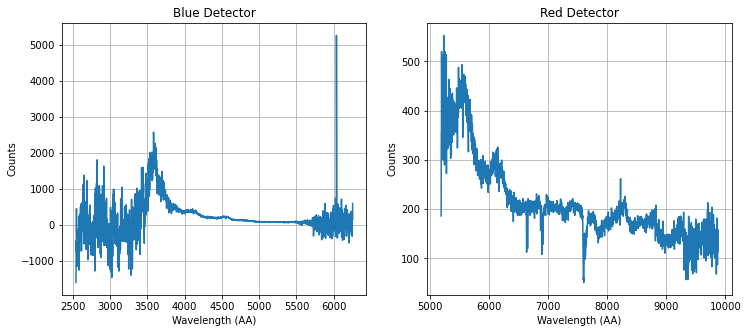

In [6]:
fig, ax = plt.subplots(1, 2,figsize=(12, 5))
ax[0].plot(blue_wav,blue_array)
ax[0].set_title('Blue Detector')
ax[0].set_xlabel('Wavelength (AA)');
ax[0].set_ylabel('Counts');
#ax[0].set_ylim(0, 700)
ax[0].grid()

ax[1].plot(red_wav, red_array)
ax[1].set_title('Red Detector')
ax[1].set_xlabel('Wavelength (AA)');
ax[1].set_ylabel('Counts');
#ax[1].set_ylim(0, 700);
ax[1].grid()

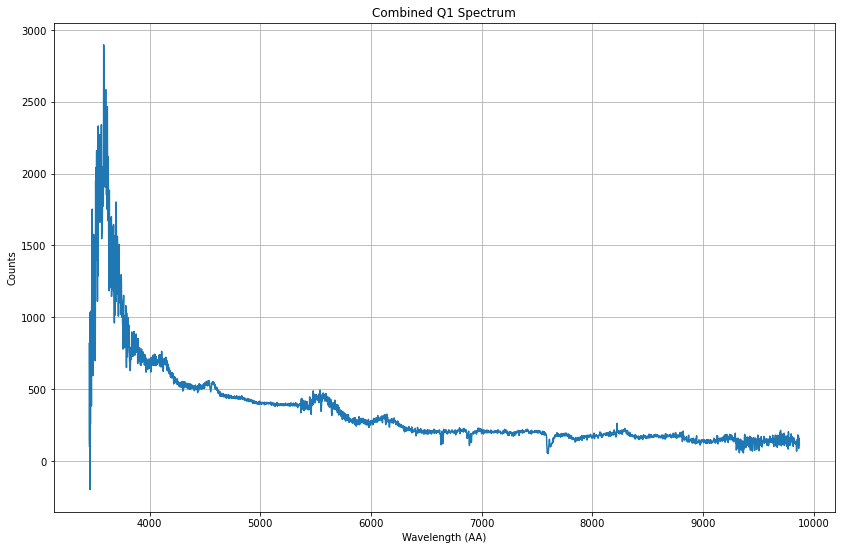

In [8]:
#Stitching together spectra and removing noise on edges
comb_wav = np.concatenate([blue_wav[500:1550],red_wav[:-79][::-1]])
comb_array = np.concatenate([(blue_array[500:1550]+320),red_array[:-79][::-1]])

fig, ax = plt.subplots(1, 1,figsize=(14, 9))
ax.plot(comb_wav, comb_array)
ax.set_title('Combined Q1 Spectrum')
ax.set_xlabel('Wavelength (AA)');
ax.set_ylabel('Counts');
ax.grid()

In [9]:
#Using a moving median window to smooth the data
from scipy.ndimage import median_filter

window_size = 3 #Loss of lines less than window_size*2 angstroms
smooth_data = median_filter(comb_array,window_size)
print(np.shape(comb_array))
np.shape(smooth_data)

(3011,)


(3011,)

In [10]:
#This was used to idenify lines for redshift. Similar to finding the peaks for wavlength calibration notebook
guessed_xvals_b = [3550,3650,4110,4550]
guess_xvals_r = [5550]

bpix = blue_pix_to_ang.inverse(guessed_xvals_b)
rpix = red_pix_to_ang.inverse(guess_xvals_r)
bpix = bpix.astype(int)
rpix = rpix.astype(int)

npixels = 50
improved_xval_guesses_b = [np.average(blue_pix[g-npixels:g+npixels],
                                    weights=blue_array[g-npixels:g+npixels]- np.median(blue_array))
                         for g in bpix]
improved_xval_guesses_r = [np.average(red_pix[g-npixels:g+npixels],
                                    weights=red_array[g-npixels:g+npixels]- np.median(red_array))
                         for g in rpix]

#Add 0,0 for line fit, ensuring y intercept as close to zero as possible
improved_xval_guesses = np.concatenate([[0],blue_pix_to_ang(improved_xval_guesses_b),red_pix_to_ang(improved_xval_guesses_r)])
improved_xval_guesses

array([   0.        , 3563.47798978, 3634.27273572, 4103.44626177,
       4540.68006718, 5551.37610075])

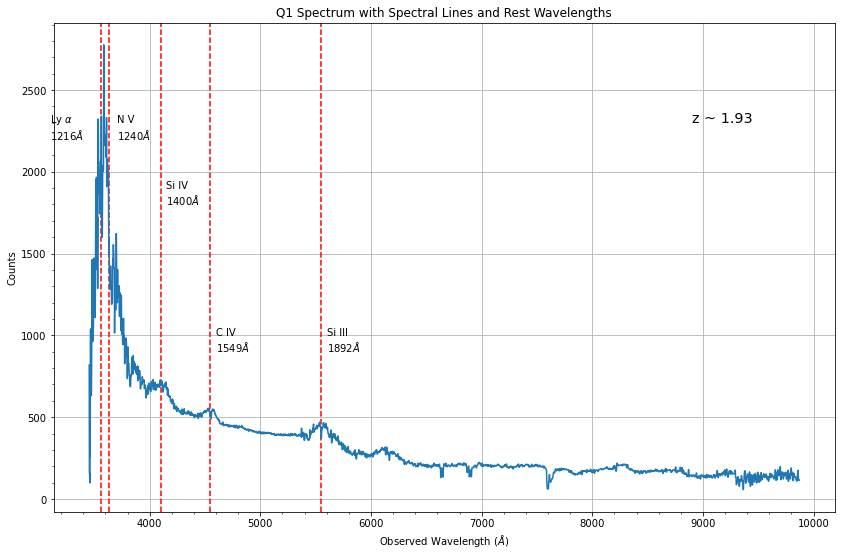

In [11]:
fig, ax = plt.subplots(1, 1,figsize=(14, 9))
for x in improved_xval_guesses[1:]:
    ax.axvline(x=x,color='red',linestyle='--')
ax.plot(comb_wav,smooth_data)


ax.text(3100,2300,'Ly $\\alpha$')
ax.text(3100,2200,'1216$\\AA$')

ax.text(3700,2300,'N V')
ax.text(3700,2200,'1240$\\AA$')
ax.text(4150,1900,'Si IV')
ax.text(4150,1800,'1400$\\AA$')
ax.text(4600,1000,'C IV')
ax.text(4600,900,'1549$\\AA$')

ax.text(5600,1000,'Si III')
ax.text(5600,900,'1892$\\AA$')

ax.text(8900,2300,'z ~ 1.93',fontsize='x-large')

ax.set_title('Q1 Spectrum with Spectral Lines and Rest Wavelengths')
ax.set_xlabel('Observed Wavelength ($\\AA$)');
ax.set_ylabel('Counts');
ax.minorticks_on()
ax.grid()
#ax.grid(which='both',linestyle=':')

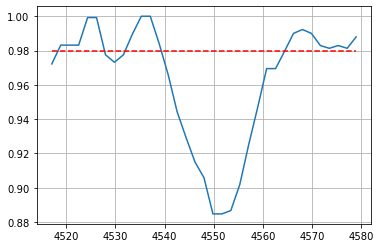

In [12]:
#Need to define a window for specutils, also need to normalize the continuum to 1
#Without continuum source, taking small window on a relatively flat part and normalizing will work

window1=585
window2=620

spec = smooth_data[window1:window2]/max(smooth_data[window1:window2])

plt.plot(comb_wav[window1:window2],spec)
plt.hlines(y=np.median(spec), xmin=min(comb_wav[window1:window2]), xmax=max(comb_wav[window1:window2]),
          color='red', linestyle='--');
plt.grid();

In [13]:
#Specutils needs flux density units
spec1 = Spectrum1D(spectral_axis=comb_wav[window1:window2]*u.AA, flux=spec*u.Unit('erg cm-2 s-1 AA-1'))
ni1 = equivalent_width(spec1, continuum = np.median(spec)*u.Unit('erg cm-2 s-1 AA-1'), regions=SpectralRegion(min(comb_wav[window1:window2])*u.AA, max(comb_wav[window1:window2])*u.AA))

In [16]:
#Comparing numbers/results
print(ni1)
line_depth = np.median(spec)-min(spec)

print(ni1/line_depth)#This equals FWHM, since EW = FWHM * depth

print(line_depth)

1.0497880421580503 Angstrom
11.07095976557496 Angstrom
0.09482358028455273


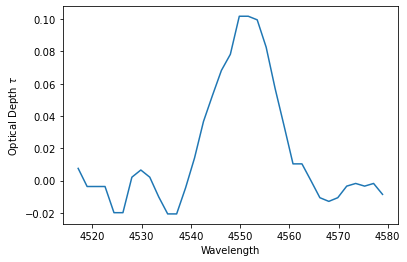

In [30]:
#Attempting second calculation without specutils
#https://www.astro.uvic.ca/~tatum/stellatm/atm11.pdf
#https://people.ast.cam.ac.uk/~pettini/Intro%20Cosmology/Lecture12.pdf

#Absorptance, where median(spec) is initial intensity, and spec is line absorbed by H dependent on wavelength
a = (np.median(spec)-(spec))/np.median(spec)

#Optical depth = -1* ln(1- a)
plt.plot(comb_wav[window1:window2], -1*np.log(1-a))
plt.xlabel('Wavelength')
plt.ylabel(r'Optical Depth $\tau$');

In [31]:
#Integrate absorptance to get EW within window in unit of wavelength (AA)
simps(a,comb_wav[window1:window2])

1.0443651651445758